# <center>Portfolio Project: Predicting<br>Loan Risk</center>
Welcome to my portfolio project, where I will build a model to predict which loans are risky. <br>
I will demonstrate the complete data processing pipeline, from data prepration, model fitting and hyperparameter tuning with state-of-the-art gradient boosting machines. <br>
Thank you for your time and reviewing my portfolio! 

**Content:** <br>
1. [Data Info & Setup](#1.)<br>
    1.1 [Creating the Target Variable](#1.1)<br>
    1.2 [Filter data to information available at loan issuance](#1.2)<br>
1. [Exploratory Data Analysis & Data Preparation](#2.)<br>
    2.1 [Text Columns & Feature Engineering](#2.1)<br>
    2.2 [Missing Data](#2.2)<br>
    2.3 [Final Preparations & Train-Test-Split](#2.3)<br>
1. [Modeling](#3.)<br>
    3.1 [Logistic Regression](#3.1)<br>
    3.2 [Support Vector Classifier with Stochastic Gradient Descent](#3.2)<br>
    3.3 [XGBoost](#3.3)<br>
1. [Conclusion](#4.)<br>   

<a id='1.'></a>

# 1. Data Info & Setup

This is a [publicly available data set](http://https://www.lendingclub.com/auth/login?login_url=%2Finfo%2Fdownload-data.action) from LendingClub, an American peer-to-peer lending company.  I will build a model to predict which loans had been not paid back completely or only with delay. This will provide valueable information for future loan decisions. 

In [1]:
# Import standard libraries
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_profiling as pp

%matplotlib inline 
sns.set_style("whitegrid")

In [2]:
# Load the data
df = pd.read_csv("../../accepted_2007_to_2018Q4.csv", low_memory=False)

<a id='1.1'></a>

## 1.1 Creating the Target Variable
There is one variable informing about loan status.
Let's have a closer look: 

In [3]:
df["loan_status"].value_counts()

Fully Paid                                             1076751
Current                                                 878317
Charged Off                                             268559
Late (31-120 days)                                       21467
In Grace Period                                           8436
Late (16-30 days)                                         4349
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     40
Name: loan_status, dtype: int64

I will use loan_status to create a binary variable, which marks problematic 
loans. This will become the **target variable** for modeling. 

In [4]:
problematic_loans = ["Charged Off", "Default", "In Grace Period", 
                     "Does not meet the credit policy. Status:Charged Off", 
                     "Late (16-30 days)", "Late (31-120 days)"]

df["problematic_loan"] = df["loan_status"].apply(lambda s: int(s in problematic_loans))

In [5]:
# I drop all current loans from analysis. We don't know whether they will 
# become problamtic loans or not and I will therefore exclude them
df = df[df["loan_status"] != "Current"]

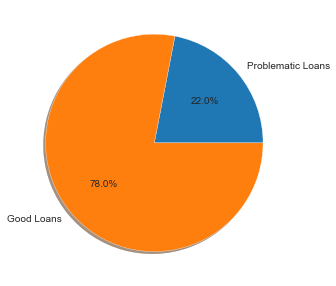

In [6]:
labels = "Problematic Loans", "Good Loans"
sizes = [df["problematic_loan"].sum()/len(df), 1 - df["problematic_loan"].sum()/len(df)]


plt.figure(figsize=(10,5))
plt.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True)

plt.show()

The dataset is imbalanced. I will return to this issue at the end of the data preparation section

<a id='1.2'></a>

## 1.2 Filter data to information available at loan issuance
The original data file contains a lot more information which were not available yet at loan issuance. Therefore this information cannot be used to predict loan risk. Through careful inspection, I have created the following list with all variables available at loan issuance and will restrict all further analyses to these variables only.  

In [7]:
available_features = ['acc_now_delinq', 'acc_open_past_24mths', 'addr_state',
 'all_util', 'annual_inc', 'annual_inc_joint', 'application_type', 'avg_cur_bal',
 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'collections_12_mths_ex_med',
 'delinq_2yrs', 'delinq_amnt', 'desc', 'disbursement_method', 'dti', 'dti_joint',
 'earliest_cr_line', 'emp_length', 'emp_title', 'fico_range_high', 'fico_range_low',
 'funded_amnt', 'grade', 'home_ownership', 'id', 'il_util', 'initial_list_status',
 'inq_fi', 'inq_last_12m', 'inq_last_6mths', 'installment', 'int_rate', 'loan_amnt',
 'max_bal_bc', 'member_id', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op',
 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_last_delinq', 'mths_since_last_major_derog',
 'mths_since_last_record', 'mths_since_rcnt_il', 'mths_since_recent_bc', 'mths_since_recent_bc_dlq',
 'mths_since_recent_inq', 'mths_since_recent_revol_delinq', 'num_accts_ever_120_pd',
 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl',
 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd_2m',
 'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'open_acc', 'open_acc_6m',
 'open_act_il', 'open_il_12m', 'open_il_24m', 'open_rv_12m', 'open_rv_24m', 'pct_tl_nvr_dlq',
 'percent_bc_gt_75', 'pub_rec', 'pub_rec_bankruptcies', 'purpose', 'revol_bal',
 'revol_bal_joint', 'revol_util', 'sec_app_chargeoff_within_12_mths', 'sec_app_collections_12_mths_ex_med',
 'sec_app_earliest_cr_line', 'sec_app_fico_range_high', 'sec_app_fico_range_low',
 'sec_app_inq_last_6mths', 'sec_app_mort_acc', 'sec_app_mths_since_last_major_derog',
 'sec_app_num_rev_accts', 'sec_app_open_acc', 'sec_app_open_act_il', 'sec_app_revol_util',
 'sub_grade', 'tax_liens', 'term', 'title', 'tot_coll_amt', 'tot_cur_bal', 'tot_hi_cred_lim',
 'total_acc', 'total_bal_ex_mort', 'total_bal_il', 'total_bc_limit', 'total_cu_tl',
 'total_il_high_credit_limit', 'total_rev_hi_lim', 'url', 'verification_status',
 'verification_status_joint', 'zip_code', 'problematic_loan']


In [8]:
df_filter = df[available_features]

In [9]:
df_filter.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1382384 entries, 0 to 2260700
Columns: 110 entries, acc_now_delinq to problematic_loan
dtypes: float64(89), int64(1), object(20)
memory usage: 1.1+ GB


The file contains over 1 million loans and 109 variables describing each loan and customer. 

<a id='2.'></a>

# 2. Exploratory Data Analysis & Data Preparation

<a id='2.1'></a>

# 2.1 Text Columns & Feature Engineering

In [10]:
#List all text columns
for c in df_filter.columns:
    if df_filter[c].dtype  == "object":
        print(c, "has", df_filter[c].nunique(), "unique values.")
        if df_filter[c].nunique() < 11: 
                print(df_filter[c].value_counts())

addr_state has 51 unique values.
application_type has 2 unique values.
Individual    1352767
Joint App       29584
Name: application_type, dtype: int64
desc has 124416 unique values.
disbursement_method has 2 unique values.
Cash         1374460
DirectPay       7891
Name: disbursement_method, dtype: int64
earliest_cr_line has 739 unique values.
emp_length has 11 unique values.
emp_title has 385454 unique values.
grade has 7 unique values.
B    400654
C    394346
A    237488
D    209286
E     97559
F     33315
G      9703
Name: grade, dtype: int64
home_ownership has 6 unique values.
MORTGAGE    682142
RENT        550448
OWN         149215
ANY            311
OTHER          182
NONE            53
Name: home_ownership, dtype: int64
id has 1382384 unique values.
initial_list_status has 2 unique values.
w    810885
f    571466
Name: initial_list_status, dtype: int64
purpose has 14 unique values.
sec_app_earliest_cr_line has 585 unique values.
sub_grade has 35 unique values.
term has 2 unique 

### Creating dummy variables 
As we can see abosve, some text columns are binary. I inspected them further and decided to transform the ones which I consider potentially predictive to dummy varibles:

In [11]:
#Creating dummy variables from potentially interesting binary categorical variables: 
df_dummies = pd.get_dummies(df_filter, columns=["term","application_type", 'disbursement_method'])

### Feature Engineering

With more exploration, I identified a few text columns with binary values. 3 text variables which have 
interesting information: <br>
- "purpose" indicates whether a customer already had prior debt
- "home_ownership" indicates whether someone owns a house with or without mortgage 
- "grade" refers to credit score grade <br>
<br>
I transform the first two variables into binary dummy variables and grade into a continuos variable. 

**Prior debt from purpose**

Text(0.5, 1.0, 'Prior Debt')

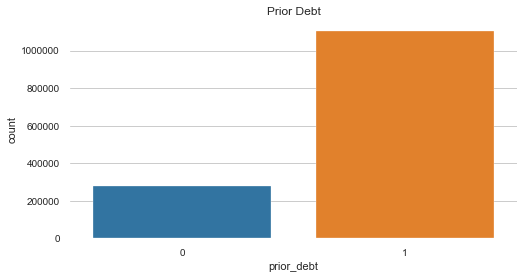

In [12]:
def check_prior_debt(s):
    if s in ["debt_consolidation", "credit_card"]:
        return 1
    else:
        return 0
    
df_dummies["prior_debt"] = df_dummies["purpose"].apply(check_prior_debt)

#Most loaners had prior debt: 
plt.figure(figsize=(8,4))
sns.countplot(df_dummies["prior_debt"])
plt.title("Prior Debt")

**Home ownership and mortgage**

Text(0.5, 1.0, 'Home ownership')

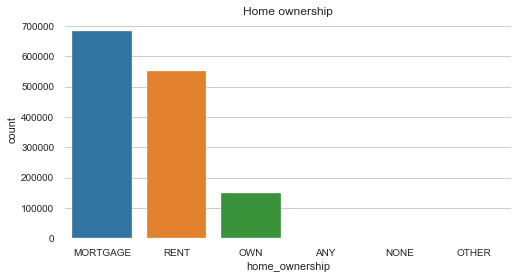

In [13]:
df_dummies["home_owner"] = df_dummies["home_ownership"].apply(lambda s: int(s == "OWN"))
df_dummies["mortgage"] = df_dummies["home_ownership"].apply(lambda s: int(s == "MORTGAGE"))

#Few loaners own a house without mortgage: 
plt.figure(figsize=(8,4))
sns.countplot(df_dummies["home_ownership"])
plt.title("Home ownership")

**Credit Card Score**

In [14]:
df_dummies["grade"].value_counts()

B    400654
C    394346
A    237488
D    209286
E     97559
F     33315
G      9703
Name: grade, dtype: int64

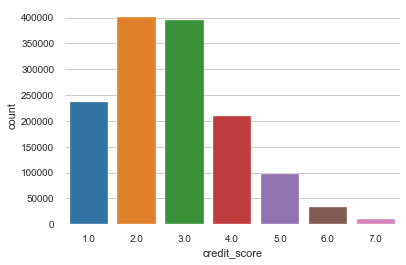

In [15]:
cs_convert = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7, "NaN": np.nan}
df_dummies["credit_score"] = df_dummies["grade"].apply(lambda s: 
                                                       cs_convert[s] if pd.notnull(s) else s)

sns.countplot(df_dummies[df_dummies["credit_score"].notnull()]["credit_score"])

### Delete text columns
After having engineered new features from some text columns and turned others into dummy variables, 
I will delete all text columns:

In [16]:
#Delete text columns irrelevant for modeling
df_dummies.drop(['id', 'member_id', 'emp_title', 'url', 'desc', 'zip_code', 'title', 'sub_grade', 
                 'emp_title', 'emp_length', 'purpose', 'addr_state', 'earliest_cr_line', 
                 'sec_app_earliest_cr_line', 'home_ownership', 'home_ownership', 
                 'initial_list_status', 'grade', 'verification_status', 'verification_status_joint'], 
                axis=1, inplace=True)

<a id='2.2'></a>

### 2.2 Missing Data

Over 2 million loans is a lot of data to process. To speed up the subsequent modeling process, I will delete rows and columns with a lot of missings.

**Missings per column**

Text(0.5, 0, 'Columns')

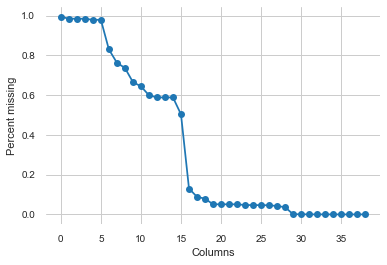

In [17]:
%matplotlib inline
missings_column = df_dummies.isnull().sum(axis=0).unique().tolist()
#Get the percentage of missing values per column
plt.plot([s/len(df_dummies) for s in sorted(missings_column, reverse=True)], marker="o")
plt.ylabel("Percent missing")
plt.xlabel("Columns")

There are columns with many missing but then there is a sudden drop from 50% to 13% missing. I will exclude all columns with more than 50% missing:

In [18]:
df_nomiss = df_dummies.dropna(axis=1, thresh=df_dummies.shape[0]*.50)

**Missings per row**

Text(0.5, 0, 'Rows')

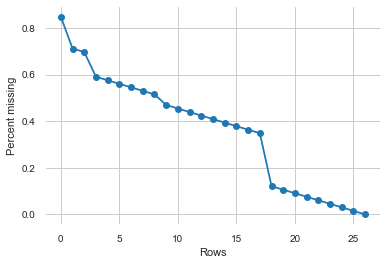

In [19]:
missings_row = df_nomiss.isnull().sum(axis=1).unique().tolist()
#Get the percentage of missing values per column
plt.plot([s/df_nomiss.shape[1] for s in sorted(missings_row, reverse=True)], marker="o")
plt.ylabel("Percent missing")
plt.xlabel("Rows")

There is a jump from around 35% to 12% missing in a row. I will drop all cases with at least 35% missing. 

In [20]:
df_nomiss = df_nomiss.dropna(axis=0, thresh=0.6*df_nomiss.shape[1])

*Quick look at the proprocessed data:*

In [21]:
df_nomiss.shape

(1332067, 66)

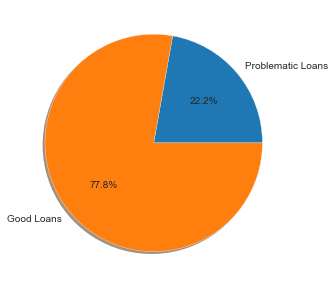

In [22]:
labels = "Problematic Loans", "Good Loans"
sizes = [df_nomiss["problematic_loan"].sum()/len(df_nomiss), 
         1 - df_nomiss["problematic_loan"].sum()/len(df_nomiss)]


plt.figure(figsize=(10,5))
plt.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True)

plt.show()

The removal of rows and columns based on missings has not changed the relative amount of problematic loans. This is good because there was no systematic connection between the problematic loans and these missing data. There are still over 1.3 million cases and 65 features.  

<a id='2.3'></a>

## 2.3 Undersampling & Train-Test-Split

1.3 million cases is a lot and will slow down modeling. I will reduce it to approximately 200,000 cases.

This is also an imbalanced dataset where the target "problematic loans" is underrepresented by a ratio of about  4:1. There is no a-priori way of knowing whether the imbalance will negatively affect model performance. Furthermore, some models also have built-in "cost-senstive" techniques which give more weight to the underrepresented class. Thus, I will create **a balanced resampled dataset and an imbalanced resampled dataset** (leaving the distribution "as is") and will train and test with both, to find the best model fit. 

**Balanced Resampled Dataset**

In [23]:
good_loans = df_nomiss[df_nomiss["problematic_loan"] == 0]
problematic_loans = df_nomiss[df_nomiss["problematic_loan"] == 1]

In the next step, I resample a higher fraction from the problematic loans, which results in a balanced dataset.

In [24]:
balanced_subsample_good = good_loans.sample(frac = 0.1)
balanced_subsample_problematic = problematic_loans.sample(frac = 0.3)

In [25]:
balanced_subsample = pd.concat([balanced_subsample_problematic, balanced_subsample_good])

In [26]:
balanced_subsample.shape

(192387, 66)

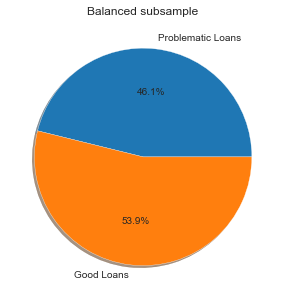

In [27]:
labels = "Problematic Loans", "Good Loans"
sizes = [balanced_subsample["problematic_loan"].sum()/len(balanced_subsample), 
         1 - balanced_subsample["problematic_loan"].sum()/len(balanced_subsample)]


plt.figure(figsize=(10,5))
plt.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True)
plt.title("Balanced subsample")
plt.show()

In [28]:
y_balanced = balanced_subsample["problematic_loan"]
X_balanced = balanced_subsample.drop("problematic_loan", axis=1)

**Imbalanced Resampled Dataset**

This time I will use the separate datasets for good and problematic to ensure that the distributions are preserved.

In [29]:
imbalanced_subsample_good = good_loans.sample(frac = 0.15)
imbalanced_subsample_problematic = problematic_loans.sample(frac = 0.15)

In [30]:
imbalanced_subsample = pd.concat([imbalanced_subsample_problematic, imbalanced_subsample_good])

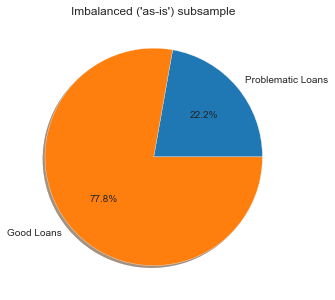

In [33]:
labels = "Problematic Loans", "Good Loans"
sizes = [imbalanced_subsample["problematic_loan"].sum()/len(imbalanced_subsample), 
         1 - imbalanced_subsample["problematic_loan"].sum()/len(imbalanced_subsample)]


plt.figure(figsize=(10,5))
plt.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True)
plt.title("Imbalanced ('as-is') subsample")
plt.show()

In [34]:
y_imbalanced = imbalanced_subsample["problematic_loan"]
X_imbalanced = imbalanced_subsample.drop("problematic_loan", axis=1)

**Train-Test-Split**

A common procedure is to split the the data into a training set, which is used to train model, and an independent test set, which is subsequently used to evaluate model performance.

A usual split is to reserve 30-40% for testing. However, this is still a large dataset so I will reduce the test sample to 20%. I will use stratification to preserve the relative amount of problematic and good loans in both sets. 

In [197]:
from sklearn.model_selection import train_test_split

In [198]:
X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_balanced, y_balanced, 
                                                                    test_size=0.20, stratify=y_balanced)

In [199]:
X_train_imb, X_test_imb, y_train_imb, y_test_imb = train_test_split(X_imbalanced, y_imbalanced, 
                                                                    test_size=0.20, stratify=y_imbalanced)

I will  save the preprocessed and subsampled dataset, so it is possible later to continue this project directly from here without the need to repeat all preprocessing steps. 

In [200]:
X_train_imb.to_pickle("LoansData_ImbalancedSubsample_Xtrain.pkl")
y_train_imb.to_pickle("LoansData_ImbalancedSubsample_ytrain.pkl")
X_test_imb.to_pickle("LoansData_ImbalancedSubsample_Xtest.pkl")
y_test_imb.to_pickle("LoansData_ImbalancedSubsample_ytest.pkl")

X_train_imbal.to_pickle("LoansData_BalancedSubsample_Xtrain.pkl")
y_train_imbal.to_pickle("LoansData_BalancedSubsample_ytrain.pkl")
X_test_imbal.to_pickle("LoansData_BalancedSubsample_Xtest.pkl")
y_test_imbal.to_pickle("LoansData_BalancedSubsample_ytest.pkl")

Next I will do some "housekeeping" and delete dataframes from memory which are not used any more. 

In [201]:
#Save the feature names (will be useful later)
features = list(df_nomiss)

#delete dataframes
del df
del df_filter
del df_dummies
del df_nomiss
del good_loans
del problematic_loans
del balanced_subsample_good
del balanced_subsample_problematic
del X_balanced
del y_balanced
del imbalanced_subsample_good
del imbalanced_subsample_problematic
del X_imbalanced
del y_imbalanced

#One of Python's "weak" spots is its handling of RAM, as it does not 
#free up memory space when variables are deleted. I will load a "garbage collection"
#module to take care of this

import gc

gc.collect()

10053

**Save Point**

Running the next cell will make it possible to continue this project from here: 

In [1]:
# Import libraries
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import gc
%matplotlib inline
sns.set_style("white")

# Load files
X_train_imb = pd.read_pickle("../../LoansData_ImbalancedSubsample_Xtrain.pkl")
y_train_imb = pd.read_pickle("../../LoansData_ImbalancedSubsample_ytrain.pkl")
X_test_imb = pd.read_pickle("../../LoansData_ImbalancedSubsample_Xtest.pkl")
y_test_imb = pd.read_pickle("../../LoansData_ImbalancedSubsample_ytest.pkl")
X_train_bal = pd.read_pickle("../../LoansData_BalancedSubsample_Xtrain.pkl")
y_train_bal = pd.read_pickle("../../LoansData_BalancedSubsample_ytrain.pkl")
X_test_bal = pd.read_pickle("../../LoansData_BalancedSubsample_Xtest.pkl")
y_test_bal = pd.read_pickle("../../LoansData_BalancedSubsample_ytest.pkl")

<a id='3.'></a>

# 3. Modeling

I will fit three different models. I will start with the "classic", which is logistic regression. Then I will use Support Vector Machines and finally XGBoost, a gradient tree boosting framework that has become very popular recently, frequently being the algortihm behind winning solutions on Kaggle and other machine learning competitions. For all models, I will use pipelines to prevent data leakage, cross validation (including stratificaiton for the imbalanced dataset), tuning of hyperparameters, and model evaluation. 

*Risk of Data Leakage:* <br>
Preprocessing steps like standardization and normalization bring the danger of data leakage, especially when combined with cross-validation. This happens when these preprocessing steps are performed before the data is split into the training and validation set. In this case, information from the validation set has "leaked" into the training set. This can be circumvented by using "pipelines", where these preprocessing steps are performed separately for each training dataset. 

*Balanced & imbalanced dataset:*<br>
I will perform the whole modeling process for both the imbalanced and balanced subsamples. For the imbalanced dataset, I will  employ two additional techniques: First, stratification during cross-validation, which ensures that the relative quantities of both classes will be maintained in all subsamples (folds). Second, I will use weighting which to give more weight to the minority class of problematic loans during model fitting. It will be interesting to see which dataset performs better. 

*Cross-validation & Stratification:*<br>
Cross-validation is a technique where the model is fit several to different parts of the data. The final model parameters are based on the means of all these different models, which reduces the model's variance or dependency on a specific dataset.

*Tuning of hyperparameters:*<br>
Finally, I will also employ GridSearch. This is a technique where several models with different hyperparameters are trained to find the configuration with the best fit. Hyperparameters are parameters which concern the general model layout but cannot be adjsuted by training. "Tuning" of hyperparamters can quickly become computationally expensive, so I will focus on a few of the most important ones for each model. 

*Model evaluation:*<br>
As evaluation metric, I will use confusion matrices and F2-scores. The F-score takes the harmonic mean of recall and specificity, and is better suited for imbalanced datasets than the more common accuracy measure. Furthermore, the F2-score gives more weight to sensitivity, at a possible increase in false positives. In this case, it means that more importance is given to identifying problematic loans.  

<a id='3.1'></a>

## 3.1 Logistic Regression

Logistic regression attempts to minimize the squared distances between predictions and actual outcomes using a Sigmoid function. There are two additional preprocessing steps need for logistic regression to work optimally: Stanardization of predictor and impuation of all missing values. <br>

In summary, these are the steps for logistic regression: 
- Standardization of predictor variables
- Imputation of missing values
- Model fitting with k-fold cross validation
- GridSearch for hyperparameter tuning
- Combine all the steps from above in a "pipeline" to prevent data leaking.
- Model evaluation with F2-scores and confusion matrices

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import plot_confusion_matrix, make_scorer, fbeta_score

**Balanced dataset**

In [7]:
#Definition of pipleline and the hyperparamters for tuning
pipe_reg_bal = Pipeline([("standardizer", StandardScaler()), 
                         ("mean_impute", SimpleImputer()), 
                         ("reg_model", LogisticRegression(solver="saga", 
                                                          max_iter=300))])
param_grid_reg = {"reg_model__C":[1.0, 1.5, 2.0], 
                  "reg_model__penalty":["l1", "l2"]}
f2_scoring = make_scorer(fbeta_score, beta=2)

In [71]:
grid_reg_bal = GridSearchCV(pipe_reg_bal, param_grid=param_grid_reg, cv=5, 
                            verbose = 1, n_jobs=-1, scoring=f2_scoring)
grid_reg_bal.fit(X_train_bal, y_train_bal)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  4.6min finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('standardizer',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('mean_impute',
                                        SimpleImputer(add_indicator=False,
                                                      copy=True,
                                                      fill_value=None,
                                                      missing_values=nan,
                                                      strategy='mean',
                                                      verbose=0)),
                                       ('reg_model',
                                        LogisticRegression(C=1.0,
                                                         

**Imbalanced Dataset**

In [72]:
#Definition of pipleline for imbalanced dataset
pipe_reg_imb = Pipeline([("standardizer", StandardScaler()), 
                         ("mean_impute", SimpleImputer()), 
                         ("reg_model", LogisticRegression(solver="saga", 
                                                          class_weight="balanced", 
                                                          max_iter=300))])

In [73]:
#Parameter grid for model fitting with stratified k-fold cross-validation
grid_reg_imb = GridSearchCV(pipe_reg_imb, param_grid=param_grid_reg, 
                            cv=StratifiedKFold(), scoring=f2_scoring, 
                            verbose = 1, n_jobs=-1)
grid_reg_imb.fit(X_train_bal, y_train_bal)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  4.5min finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('standardizer',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('mean_impute',
                                        SimpleImputer(add_indicator=False,
                                                      copy=True,
                                                      fill_value=None,
                                                      missing_values=nan,
                                                      strategy='mean',
                                                      verbose=0)),
                                       ('reg_model',
                                        LogisticRe

**Evaluation of Logistic Regression Models**

Text(0.5, 1.0, 'Balanced Subsampling\n\nOptimal hyperparameters:\nC=1.5, penalty=l1\n\nF2-Score = 0.58')

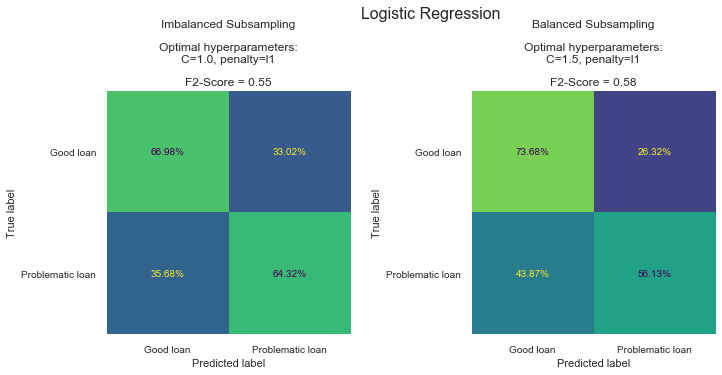

In [89]:
#Preparation of text output
f2_reg_imb = fbeta_score(y_test_imb, grid_reg_imb.predict(X_test_imb), 2)
f2_reg_bal = fbeta_score(y_test_bal, grid_reg_bal.predict(X_test_bal), 2)
title_reg_imb = ('Imbalanced Subsampling\n\n' + 'Optimal hyperparameters:\n' + 
                 ', '.join("{}={}".format(key[11:],val) for (key,val) 
                           in grid_reg_imb.best_params_.items()) + '\n\nF2-Score = ' + 
                 str(round(f2_reg_imb, ndigits=2)))
title_reg_bal = ('Balanced Subsampling\n\n' + 'Optimal hyperparameters:\n' + 
                 ', '.join("{}={}".format(key[11:],val) for (key,val) 
                           in grid_reg_bal.best_params_.items()) + '\n\nF2-Score = ' + 
                 str(round(f2_reg_bal, ndigits=2)))

#Creating the figure
fig, ax = plt.subplots(1,2, figsize=(12,6))
fig.suptitle('Logistic Regression', fontsize =16)

#imbalanced classifiction (left side)
pcm_imb = plot_confusion_matrix(grid_reg_imb, X_test_imb, y_test_imb, normalize="true", 
                                ax = ax[0], values_format=".2%", 
                                display_labels=["Good loan", "Problematic loan"])
pcm_imb.im_.set_clim(0.1,0.9)
pcm_imb.im_.colorbar.remove()
ax[0].set_title(title_reg_imb)

#balanced classification (right side)
pcm_bal = plot_confusion_matrix(grid_reg_bal, X_test_bal, y_test_bal, normalize="true", 
                                ax = ax[1], values_format=".2%", 
                                display_labels=["Good loan", "Problematic loan"])
pcm_bal.im_.set_clim(0.1,0.9)
pcm_bal.im_.colorbar.remove()
#pcm_bal.im_.axes.yaxis.set_visible(False)
ax[1].set_title(title_reg_bal)

**Interpretation of Logistic Regression Outcomes**

In the confusion matrices, we see the classication  for imbalanced (left) and balanced subsampling (right). While the imbalanced subsampling led to a slightly better sensitivity of 64% (percentage of problematic loans correctly identified), it did so at the cost of an increased rate of false positives (33% vs 26%). <br>
Somewhat missleadingly, the F2-score is lower for the imbalanced dataset, which  performs slightly better according to the confusion matrix. This is because in terms of absolute values, there are much more good loans in the imbalanced dataset and therefore also more  good loans missclassified as problematic loans, which lowers the F2-score.<br>
However, neither of the two logistic regression models performed very good. Regression models make a lot of assumptions about the predictor variables, e.g. normally distributed, independent from one another (no multicollinearity), homoscedastictiy. Carefullying checking these and correcting whenever possible might lead to some improvements. However, while logistic regression is "the classic classifier", nowadays there are more modern approaches which often outperform regression. 
I will move on to Support Vector Classifier and Gradient Boosting Machines, two machine learning algorithms which generally perform well and also are good complementary strategies to logsitic regression (e.g. see [Olson et al., 2017](https://arxiv.org/abs/1708.05070)). 

<a id='3.2'></a>

## 3.2 Support Vector Classifier with Stochastic Gradient Descent

Support Vector Classifier (SVC) is a non-parametric estimator with a different approach from other machine learning algorithms, and can sometimes yield good results when others fail. In very short, SVC tries to separate observations in the feature space by drawing hyperplanes between different categories. 
However, SVC doesn't scale very well with big datasets. I will overcome this problem by implementing a linear SVC model with Stochastic Gradient Descent (SGD), which is an iterative, random, and faster method to optimize the cost function. 

Like logistic regression, SGD demands standardized and imputed data. The steps are very similar to logistic regression: 
- Normalization of predictor variables
- Imputation of missing values
- Model fitting with k-fold cross validation
- GridSearch for hyperparameter tuning
- Combine all the steps from above in a "pipeline" to prevent data leaking.
- Model evaluation with F1-scores and confusion matrices

**Balanced Dataset**

In [84]:
from sklearn.linear_model import SGDClassifier

In [90]:
#Definition of pipleline and the hyperparamters for tuning
pipe_sgd_bal = Pipeline([("standardizer", StandardScaler()), 
                         ("mean_impute", SimpleImputer()), 
                         ("sgd_model", SGDClassifier())])
param_grid_sgd = [{"sgd_model__penalty":["l2", "l1"], 
                   "sgd_model__alpha":[0.00001, 0.0001, 0.001],
                   "sgd_model__learning_rate":['optimal']},
                  {"sgd_model__penalty":["l2", "l1"], 
                   "sgd_model__alpha":[0.00001, 0.0001, 0.001],
                   "sgd_model__learning_rate":['adaptive'],
                   "sgd_model__eta0":[0.00001, 0.0001, 0.001, 0.01, 0.1]}]

In [91]:
grid_sgd_bal = GridSearchCV(pipe_sgd_bal, param_grid=param_grid_sgd, cv=5, 
                            scoring=f2_scoring, verbose = 2, n_jobs=-1)
grid_sgd_bal.fit(X_train_bal, y_train_bal)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   20.0s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  1.7min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('standardizer',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('mean_impute',
                                        SimpleImputer(add_indicator=False,
                                                      copy=True,
                                                      fill_value=None,
                                                      missing_values=nan,
                                                      strategy='mean',
                                                      verbose=0)),
                                       ('sgd_model',
                                        SGDClassifier(alpha=0.0001,
                                                      a

**Imbalanced Dataset**

In [92]:
#Definition of pipleline
pipe_sgd_imb = Pipeline([("standardizer", StandardScaler()),
                         ("mean_impute", SimpleImputer()), 
                         ("sgd_model", SGDClassifier(class_weight="balanced"))])

In [93]:
#Parameter grid for model fitting with stratified k-fold cross-validation
grid_sgd_imb = GridSearchCV(pipe_sgd_imb, param_grid=param_grid_sgd, cv=StratifiedKFold(), 
                            scoring=f2_scoring, verbose = 2, n_jobs=-1)
grid_sgd_imb.fit(X_train_imb, y_train_imb)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   17.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  2.0min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('standardizer',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('mean_impute',
                                        SimpleImputer(add_indicator=False,
                                                      copy=True,
                                                      fill_value=None,
                                                      missing_values=nan,
                                                      strategy='mean',
                                                      verbose=0)),
                                       ('sgd_model',
                                        SGDClassif

**Evaluation of Support Vector Classifier**

Text(0.5, 1.0, 'Balanced Subsampling\n\nOptimal hyperparameters:\nalpha=1e-05, learning_rate=optimal, penalty=l2\n\nF2-Score = 0.61')

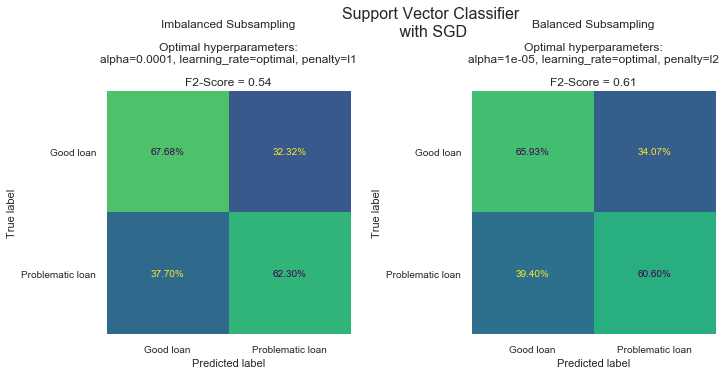

In [95]:
#Preparation of text output
f2_sgd_imb = fbeta_score(y_test_imb, grid_sgd_imb.predict(X_test_imb), 2)
f2_sgd_bal = fbeta_score(y_test_bal, grid_sgd_bal.predict(X_test_bal), 2)
title_sgd_imb = ('Imbalanced Subsampling\n\n' + 'Optimal hyperparameters:\n' + 
                 ', '.join("{}={}".format(key[11:],val) 
                           for (key,val) in grid_sgd_imb.best_params_.items()) + 
                 '\n\nF2-Score = ' + str(round(f2_sgd_imb, ndigits=2)))
title_sgd_bal = ('Balanced Subsampling\n\n' + 'Optimal hyperparameters:\n' + 
                 ', '.join("{}={}".format(key[11:],val) 
                           for (key,val) in grid_sgd_bal.best_params_.items()) + 
                 '\n\nF2-Score = ' + str(round(f2_sgd_bal, ndigits=2)))

#Creating the figure
fig, ax = plt.subplots(1,2, figsize=(12,6))
fig.suptitle('Support Vector Classifier\n with SGD', fontsize =16)

#imbalanced classifiction (left side)
pcm_imb = plot_confusion_matrix(grid_sgd_imb, X_test_imb, y_test_imb, normalize="true", ax = ax[0], 
                                values_format=".2%", display_labels=["Good loan", "Problematic loan"])
pcm_imb.im_.set_clim(0.1,0.9)
pcm_imb.im_.colorbar.remove()
ax[0].set_title(title_sgd_imb)

#balanced classification (right side)
pcm_bal = plot_confusion_matrix(grid_sgd_bal, X_test_bal, y_test_bal, normalize="true", ax = ax[1], 
                                values_format=".2%", display_labels=["Good loan", "Problematic loan"])
pcm_bal.im_.set_clim(0.1,0.9)
pcm_bal.im_.colorbar.remove()
#pcm_bal.im_.axes.yaxis.set_visible(False)
ax[1].set_title(title_sgd_bal)

**Interpretation of Support Vector Classifier outcomes**

The two SVC models perform very similarly, with the imbalanced classification leading to a marginally better result. Also, SVC performs very similarly to logistic regression, which has a marginally better recall (64% vs. 62%) for the imbalanced dataset. 

<a id='3.3'></a>

## 3.3 XGBoost

Boosting is a sequential ensemble method. A basic model is trained on the data. Every subsequent model takes the previous model's error and tries to improve on that. While the ensemble method can be combined with any machine learning algorithm, decision trees have proven to be particularly fruitful. 
XGBoost combines this with a gradient boosting algorithm, which is used to minimize errors in subsequent models. 

Decision Trees make no assumptions about the distributions of the features, so no scaling is needed. Also no imputation for missing values is necessary, becasue one  of the innovations of XGBoost is that it incorporates missing values into their decision trees ("Sparsity-Aware Split Finding"). Without any further preprocessing steps, there is no need to build a pipeline and I will directly go to: 
- GridSearch for hyperparameter tuning
- Model evaluation with F2-scores and confusion matrices

**Balanced Dataset**

In [6]:
import xgboost as xgb

*First GridSearch* <br>
XGBoost has a lot of parameters to tune, and it takes long to run it. Hence I will use a stepwise approach, first focusing on the learning rate, which might be the most important parameter. In a second step, I will tune tree depth, and regularization strength. These choices are based on suggestions by experts and various additional trials which I have left away for brevity.

In [128]:
#I have done some additional runs which I excluded from this showcase project,
#but they guide my choice here of max_depth and reg_alpha
xbg_bal = xgb.XGBClassifier(n_estimators = 500, max_depth=6, reg_alpha=1, n_jobs=-1)

In [129]:
param_grid_xgb_1 = dict(learning_rate=[0.2, 0.1, 0.01, 0.001])

In [130]:
grid_xgb_bal = GridSearchCV(xbg_bal, param_grid=param_grid_xgb_1, cv=5, 
                            scoring=f2_scoring, verbose = 4, n_jobs=-1)
grid_xgb_bal.fit(X_train_bal, y_train_bal)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  11 out of  20 | elapsed: 21.5min remaining: 17.6min
[Parallel(n_jobs=-1)]: Done  17 out of  20 | elapsed: 26.8min remaining:  4.7min
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed: 27.0min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=6, min_child_weight=1,
                                     missing=None, n_estimators=500, n_jobs=-1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=1, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'learning_rate': [0.2, 0.1, 0.01, 0.001]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(f

In [132]:
grid_xgb_bal.best_params_

{'learning_rate': 0.1}

*Second GridSearch*

In [136]:
xbg_bal = xgb.XGBClassifier(learning_rate=0.1, n_estimators = 500, n_jobs=-1)

In [137]:
param_grid_xgb_2 = dict(max_depth=[4,6,8], reg_alpha=[0,1,10])

In [138]:
grid_xgb_bal = GridSearchCV(xbg_bal, param_grid=param_grid_xgb_2, cv=5, 
                            scoring=f2_scoring, verbose = 4, n_jobs=-1)
grid_xgb_bal.fit(X_train_bal, y_train_bal)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 13.2min
[Parallel(n_jobs=-1)]: Done  42 out of  45 | elapsed: 60.1min remaining:  4.3min
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed: 60.3min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=500, n_jobs=-1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'max_depth': [4, 6, 8], 'reg_alpha': [0, 1, 10]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_s

**Imbalanced Dataset**

*First GridSearch*

In [117]:
xbg_imb = xgb.XGBClassifier(n_estimators = 500, max_depth=4, reg_alpha=1, n_jobs=-1)

In [118]:
#Parameter grid for model fitting with stratified k-fold cross-validation:
#scale_pos_weight is the weighting factor in XGBoost, and the developers
#suggest tuning it. 
param_grid_xgb_imb = dict(learning_rate=[0.1, 0.01], 
                          scale_pos_weight= [1, 2, 4])
grid_xgb_imb = GridSearchCV(xbg_imb, param_grid=param_grid_xgb_imb, 
                            cv=StratifiedKFold(), scoring=f2_scoring, 
                            verbose = 4, n_jobs=-1)
grid_xgb_imb.fit(X_train_imb, y_train_imb)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 14.1min
[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed: 21.3min remaining:  6.5min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 25.9min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=4, min_child_weight=1,
                                     missing=None, n_estimators=500, n_jobs=-1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=1, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.01],
                         'scale_pos_weight': [1, 2

In [135]:
grid_xgb_imb.best_params_

{'learning_rate': 0.01, 'scale_pos_weight': 4}

*Second GridSearch*

In [139]:
xbg_imb = xgb.XGBClassifier(scale_pos_weight=4, n_estimators = 500, n_jobs=-1)

In [140]:
param_grid_xgb_imb = dict(learning_rate=[0.01, 0.001], 
                         max_depth=[4,6,8], reg_alpha=[0,1,10])
grid_xgb_imb = GridSearchCV(xbg_imb, param_grid=param_grid_xgb_imb, 
                            cv=StratifiedKFold(), scoring=f2_scoring, 
                            verbose = 4, n_jobs=-1)
grid_xgb_imb.fit(X_train_imb, y_train_imb)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 15.2min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed: 128.8min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=500, n_jobs=-1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=4, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.001], 'max_depth': [4, 6, 8],
                        

**Evaluation of XGBoost**

Text(0.5, 1.0, 'Balanced Subsampling\n\nOptimal hyperparameters:\nlearning_rate=0.1\nmax_depth=4, reg_alpha=10\n\nF2-Score = 0.62')

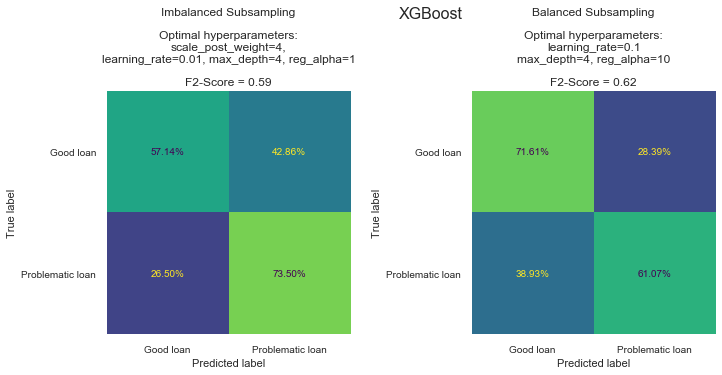

In [147]:
#Preparation of text output
f2_xgb_imb = fbeta_score(y_test_imb, grid_xgb_imb.predict(X_test_imb), 2)
f2_xgb_bal = fbeta_score(y_test_bal, grid_xgb_bal.predict(X_test_bal), 2)
title_xgb_imb = ('Imbalanced Subsampling\n\n' + 'Optimal hyperparameters:\nscale_post_weight=4,\n' + 
                 ', '.join("{}={}".format(key,val) 
                           for (key,val) in grid_xgb_imb.best_params_.items()) + 
                 '\n\nF2-Score = ' + str(round(f2_xgb_imb, ndigits=2)))
title_xgb_bal = ('Balanced Subsampling\n\n' + 'Optimal hyperparameters:\nlearning_rate=0.1\n' + 
                 ', '.join("{}={}".format(key,val) 
                           for (key,val) in grid_xgb_bal.best_params_.items()) + 
                 '\n\nF2-Score = ' + str(round(f2_xgb_bal, ndigits=2)))

#Creating the figure
fig, ax = plt.subplots(1,2, figsize=(12,6))
fig.suptitle('XGBoost', fontsize =16)

#imbalanced classifiction (left side)
pcm_imb = plot_confusion_matrix(grid_xgb_imb, X_test_imb, y_test_imb, normalize="true", ax = ax[0], 
                                values_format=".2%", display_labels=["Good loan", "Problematic loan"])
pcm_imb.im_.set_clim(0.1,0.9)
pcm_imb.im_.colorbar.remove()
ax[0].set_title(title_xgb_imb)

#balanced classification (right side)
pcm_bal = plot_confusion_matrix(grid_xgb_bal, X_test_bal, y_test_bal, normalize="true", ax = ax[1], 
                                values_format=".2%", display_labels=["Good loan", "Problematic loan"])
pcm_bal.im_.set_clim(0.1,0.9)
pcm_bal.im_.colorbar.remove()
#pcm_bal.im_.axes.yaxis.set_visible(False)
ax[1].set_title(title_xgb_bal)

**Interim-Interpretation of XGBoost**

XGBoost achieved the highest recall rate of all models at 74% for the imbalanced dataset, however at a "cost" of 43% missclassified false positives. I think the outcome for the balanced dataset is more interesting, which achieved a recall rate of still 61%, by keeping the false positives at 28%. XGBoost performed better than SVC and logistic regression, though not by a lot. Let's explore the XGBoost model for the balanced dataset more. 

**Feature Importance and more hyperparameter tuning**

For XGBoost, the prediction performance can sometimes be improved by employing by using row and column subsampling, as another technique to avoid overfitting. However, it is advisable to select features based on importance before employing column subsampling, as otherwise some iterations might end up with features only with very little predictive value. 

In this last attempt, I will do the following changes: 
- focus on the balanced dataset only 
- perform feature selection before model fitting
- employ row and column subsampling
- increase the folds for cross-validation from 5 to 10
- change the evaluation metric from F2 to F1. F1 gives equal weight to false-positives and false-negative errors. Let's see if this helps to decrease the false positive rate. 

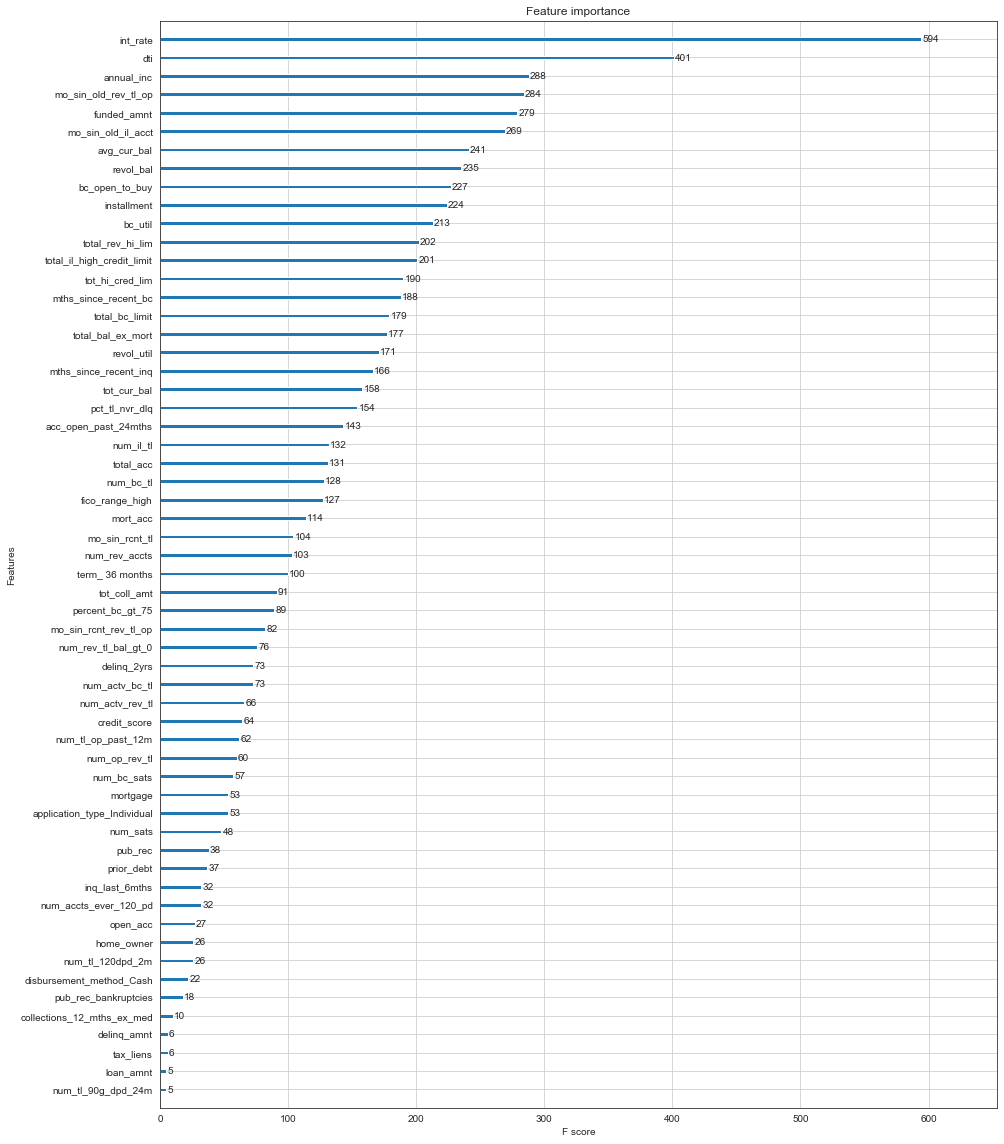

In [22]:
xgb.plot_importance(grid_xgb_bal.best_estimator_)
fig = plt.gcf()
fig.set_size_inches(15, 20)

Unsuprisingly, the two most relevant features are the interest rate and the debt-to-income ratio. The rest of the features show an almost continuous cascade of decreasing importance, and only very few features have close to no predictive value. Gaps are optimal candidates for feature selection thresholds. There is not a very clear gap, but I will take the one where the importance drops from 48 to 38 and exclude all features with importance at 38 and below. 

In [4]:
X_train_bal.drop(['num_tl_90g_dpd_24m', 'loan_amnt', 'tax_liens', 'delinq_amnt', 'collections_12_mths_ex_med', 
                  'pub_rec_bankruptcies', 'disbursement_method_Cash', 'num_tl_120dpd_2m', 'home_owner', 'open_acc', 
                  'num_accts_ever_120_pd', 'inq_last_6mths', 'prior_debt', 'pub_rec'], axis=1, inplace=True)
X_test_bal.drop(['num_tl_90g_dpd_24m', 'loan_amnt', 'tax_liens', 'delinq_amnt', 'collections_12_mths_ex_med', 
                  'pub_rec_bankruptcies', 'disbursement_method_Cash', 'num_tl_120dpd_2m', 'home_owner', 'open_acc', 
                  'num_accts_ever_120_pd', 'inq_last_6mths', 'prior_debt', 'pub_rec'], axis=1, inplace=True)

In [10]:
xbg_bal_2 = xgb.XGBClassifier(n_estimators = 500, learning_rate=0.1, 
                              max_depth=4, reg_alpha=10, n_jobs=-1)
param_grid_xgb_2 = {'colsample_bytree': [0.5, 0.75, 1], 'subsample': [0.5, 0.75, 1]}
grid_xgb_bal_2 = GridSearchCV(xbg_bal_2, param_grid=param_grid_xgb_2, cv=10, 
                              scoring='f1', verbose = 4, n_jobs=-1)

In [12]:
grid_xgb_bal_2.fit(X_train_bal, y_train_bal)

Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed: 66.7min finished


GridSearchCV(cv=10, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=4, min_child_weight=1,
                                     missing=None, n_estimators=500, n_jobs=-1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=10, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'colsample_bytree': [0.5, 0.75, 1],
                         'subsample': [0.5, 0.75, 1]},
             pre_dispatch='2*n_jobs', refit=True, return_tra

XGBoost, Finetuning with Balanced Subsampling

Optimal hyperparameters:
colsample_bytree=1, subsample=1

F2-Score = 0.63


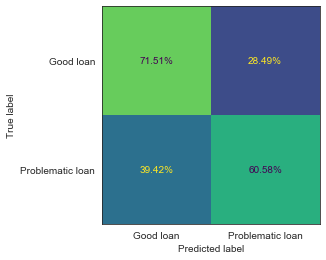

In [26]:
#Preparation of text output
f1_xgb_bal = fbeta_score(y_test_bal, grid_xgb_bal_2.predict(X_test_bal), 1)
title_xgb_bal = ('XGBoost, Finetuning with Balanced Subsampling\n\n' + 'Optimal hyperparameters:\n' + 
                 ', '.join("{}={}".format(key,val) 
                           for (key,val) in grid_xgb_bal_2.best_params_.items()) + 
                 '\n\nF2-Score = ' + str(round(f1_xgb_bal, ndigits=2)))

print(title_xgb_bal)
#Creating the figure
#fig, ax = plt.subplots(figsize=(12,6))
#fig.suptitle('XGBoost', fontsize =16)


pcm_bal = plot_confusion_matrix(grid_xgb_bal_2, X_test_bal, y_test_bal, normalize="true",  
                                values_format=".2%", display_labels=["Good loan", "Problematic loan"])
pcm_bal.im_.set_clim(0.1,0.9)
pcm_bal.im_.colorbar.remove()
#pcm_bal.im_.axes.yaxis.set_visible(False)


**Interpretation of XGBoost Outcomes** 

The best parameters subsampling of features (columns) nor of cases (rows) is 1 in both cases, which is equal to no subsampling. Thus, subsampling brings no advantage. In comparison to the previous outcome for the balanced subsample, the recall decreased ever so slightly from 61.07% to 60.58%, while the 28.39% to 28.49%. Some additional model fits, which I leave away for brevity, showed that these slight changes are caused by droping the weakest features. One should keep in mind that I have set the trees per model to 500, and appearently some trees have made use even of these weakest features. I also explored different scoring methods (such as AUC), which lead to no improvement. Finally, increasing the folds for cross-validation from 5 to 10 also made no difference. <br>
In summary, I have reached a point where tuning the model's hyperparameters does not lead to further improvements in model fit. 

<a id='4.'></a>

# 4. Conclusion

In this project, I used real data from the company LendingClub to predict which loans would become problematic, i.e. loaners would be delayed in payment or unable to pay. I applied three different machine learning algorithms to this problem, namely logistic regression, support vector machines, and XGBoost. I used two samples for each model, one where I balanced the distributions for good and problematic loans, and another one which contained the original distribution of loans and instead I used various weighting techniques to give more importance to problematic loans. Overall, the differences between models and the two samples were small, but XGBoost based on the balanced sample performed best. 

However, none of the models performed excellent. Obviously, LendingClub has its own algorithms to decide which loans to approve off. I did the analysis on approved loans only, i.e. loans that have "passed" the checks by LendingClub. It seems there is little space left to improve. One possibility which I would explore if this was a real client is gaining a better understanding of the features through conversations with the client, and subsequently spend more time on feature engineering. 

It utlimately boils down to risk management: XGBoost is able to identify most problematic loans, at a cost of rejecting some unproblematic loans (false positives). Let's use a final confusion matrix to see what this means in absolute numbers: 

The "best" solution for predicting problematic loans:
XGBoost based on balanced subsample, used on an
independent imbalanced testsample


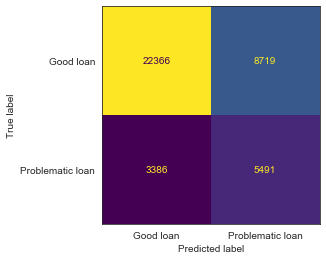

In [43]:
title_xgb_bal = ('The "best" solution for predicting problematic loans:\n' +
                 'XGBoost based on balanced subsample, used on an\n'
                'independent imbalanced testsample')
print(title_xgb_bal)
pcm_bal = plot_confusion_matrix(grid_xgb_bal, X_test_imb, y_test_imb, values_format= '.0f',
                                display_labels=["Good loan", "Problematic loan"])
#pcm_bal.im_.set_clim(0.1,0.9)
pcm_bal.im_.colorbar.remove()

For a test dataset of 39962 loans, the XGBoost algorithm could have prevented 5491 problematic loans. However, it would have also stopped 8719 good loans from being issued. For future loans, it makes more sense to think in percentage, as used before: About 61% of problematic loans could be prevented, at the cost missclassifying and rejecting 28% of good loans. 